In [ ]:
# mount google disk
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import json
import pandas as pd

In [ ]:
with open("gdrive/My Drive/dex-data/stats_2022-01.json") as stats_1, \
     open("gdrive/My Drive/dex-data/stats_2022-02.json") as stats_2, \
     open("gdrive/My Drive/dex-data/stats_2022-03.json") as stats_3, \
     open("gdrive/My Drive/dex-data/trades_with_best_params_2022-01.json") as params_1, \
     open("gdrive/My Drive/dex-data/trades_with_best_params_2022-02.json") as params_2, \
     open("gdrive/My Drive/dex-data/trades_with_best_params_2022-03.json") as params_3:
  stats_2022_01 = json.load(stats_1)
  stats_2022_02 = json.load(stats_2)
  stats_2022_03 = json.load(stats_3)
  best_params_2022_01 = json.load(params_1)
  best_params_2022_02 = json.load(params_2)
  best_params_2022_03 = json.load(params_3)

In [ ]:
signal_stats = pd.DataFrame()
for stat in (stats_2022_01 + stats_2022_02 + stats_2022_03):
  signal_stats = signal_stats.append(stat["second"], ignore_index=True)

signal_stats.drop('average_price', inplace=True, axis=1)
signal_stats["const"] = 1

best_params = pd.DataFrame()
for trade in (best_params_2022_01 + best_params_2022_02 + best_params_2022_03):
  best_params = best_params.append(trade["best_params"], ignore_index=True)
best_params["has_profit"] = best_params["has_profit"].astype(int)

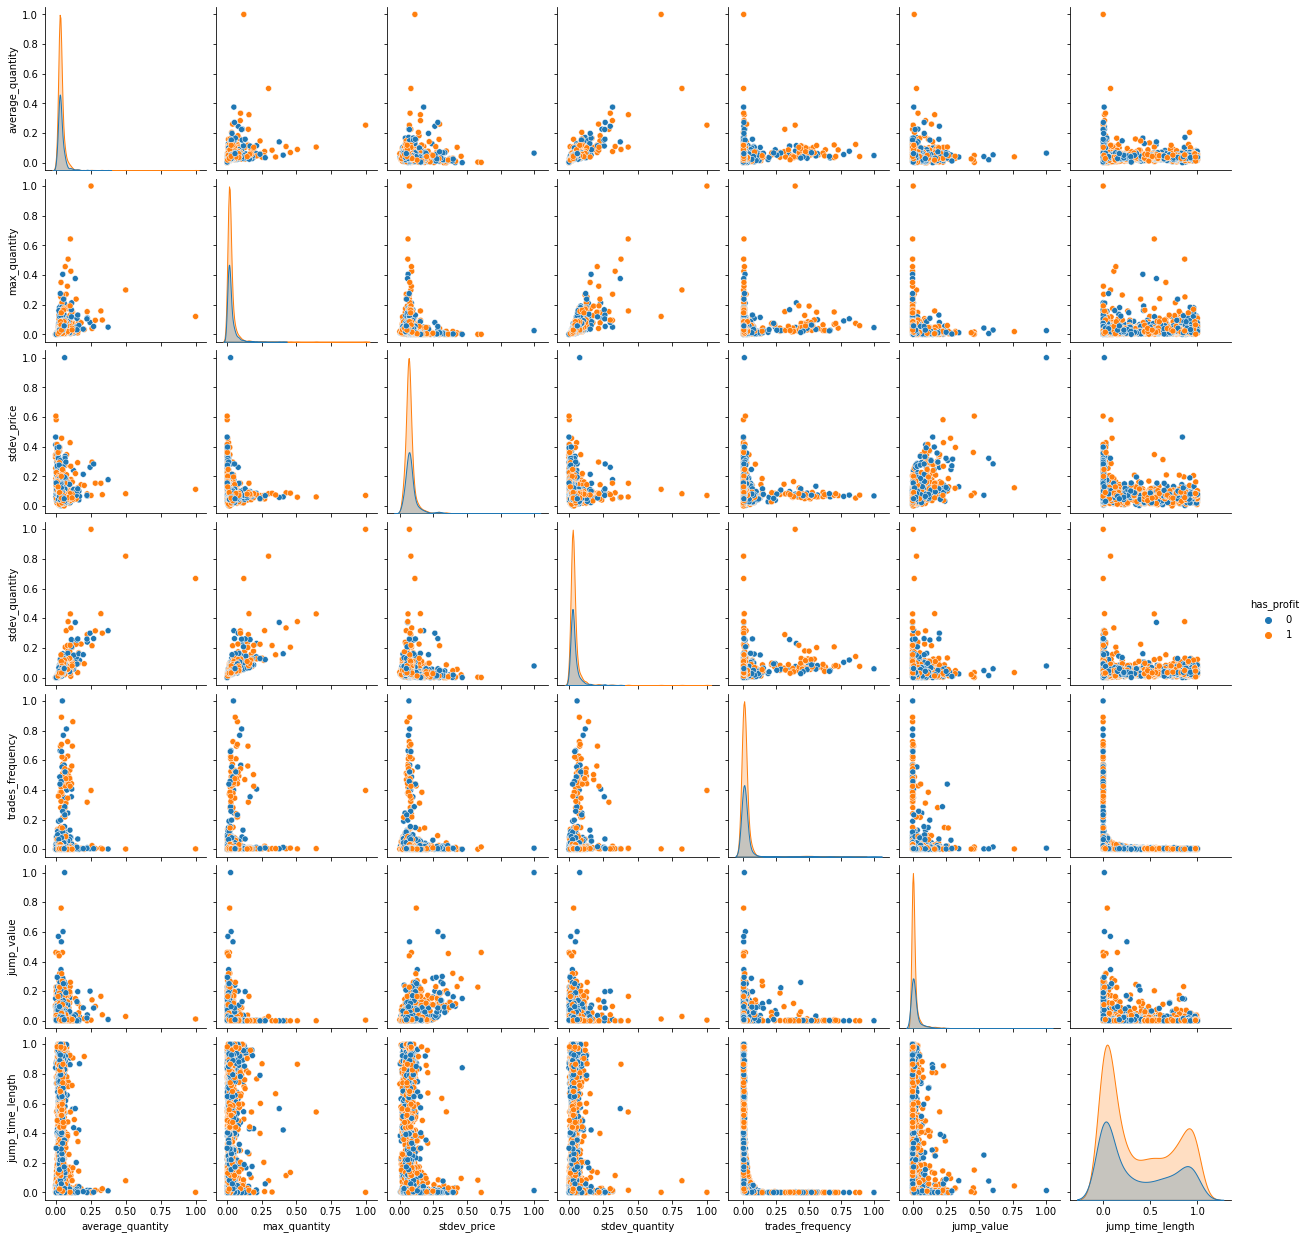

In [ ]:
import seaborn as sns
lol = signal_stats.loc[:, "average_quantity" : "jump_time_length"]
norm_lol = (lol-lol.mean())/lol.std()
norm_lol = (norm_lol-norm_lol.min())/(norm_lol.max()-norm_lol.min())
draw_data = pd.concat([norm_lol, best_params["has_profit"]], axis=1)
sns.pairplot(draw_data, hue='has_profit')

In [ ]:
!pip install umap-learn
import umap
reducer = umap.UMAP(n_components=3)
embedding = reducer.fit_transform(norm_lol.values)
embedding.shape

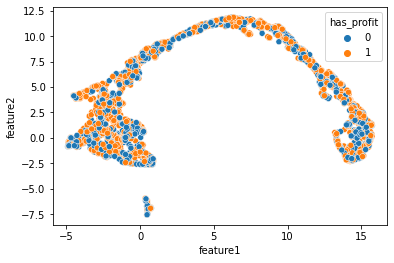

In [ ]:
umap_draw_data = pd.DataFrame({'feature1': embedding[:, 0], 'feature2': embedding[:, 1]})
umap_draw_data = pd.concat([umap_draw_data, best_params["has_profit"]], axis=1)
sns.scatterplot(data=umap_draw_data, x="feature1", y="feature2", hue="has_profit")

Смотрим, с какой части трейдов мы чисто теоретически могли что-то заработать

In [ ]:
df_total = pd.concat([signal_stats, best_params], axis=1)
#df_total = df_total[df_total.jump_time_length > 100]
#df_total = df_total[df_total.max_quantity < 1300]

In [ ]:
print(f"Часть теоретически успешных: {df_total[df_total.has_profit == 1].shape[0] / df_total.shape[0]}")

Часть теоретически успешных: 0.6617752326413744


In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_total, test_size=0.3)

X_train = train.loc[:, "average_quantity" : "const"]
X_test = test.loc[:, "average_quantity" : "const"]
Y_train_profit_threshold = train.loc[:, "profit_threshold" : "profit_threshold"]
Y_train_loss_threshold = train.loc[:, "loss_threshold" : "loss_threshold"]
Y_train_has_profit = train.loc[:, "has_profit" : "has_profit"]
Y_test_profit_threshold = test.loc[:, "profit_threshold" : "profit_threshold"]
Y_test_loss_threshold = test.loc[:, "loss_threshold" : "loss_threshold"]
Y_test_has_profit = test.loc[:, "has_profit" : "has_profit"]

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, Y_train_has_profit)
model.score(X_test, Y_test_has_profit)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6543504171632897

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=1)
model.fit(X_train, Y_train_has_profit)
model.score(X_test, Y_test_has_profit)

0.6424314660309892

[Text(0.5, 0.75, 'jump_time_length <= 15.5\ngini = 0.442\nsamples = 1955\nvalue = [645, 1310]\nclass = profit'),
 Text(0.25, 0.25, 'gini = 0.491\nsamples = 398\nvalue = [173, 225]\nclass = profit'),
 Text(0.75, 0.25, 'gini = 0.422\nsamples = 1557\nvalue = [472, 1085]\nclass = profit')]

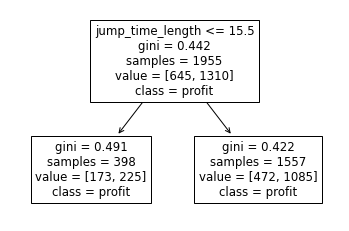

In [ ]:
from sklearn import tree
tree.plot_tree(
    model,
    feature_names=list(X_train.columns),
    class_names=["no profit", "profit"]
    )

In [ ]:
# Удалим все прыжки, длина которых меньше 100мс и посмотрим на прирост
print(f"Было: {df_total[df_total.has_profit == 1].shape[0] / df_total.shape[0]}")
df_total = df_total[df_total.jump_time_length > 100]
print(f"Стало: {df_total[df_total.has_profit == 1].shape[0] / df_total.shape[0]}")

Было: 0.6617752326413744
Стало: 0.6815804764671702


[Text(0.5, 0.75, 'max_quantity <= 2089.5\ngini = 0.429\nsamples = 1204\nvalue = [375, 829]\nclass = profit'),
 Text(0.25, 0.25, 'gini = 0.413\nsamples = 1056\nvalue = [308, 748]\nclass = profit'),
 Text(0.75, 0.25, 'gini = 0.496\nsamples = 148\nvalue = [67, 81]\nclass = profit')]

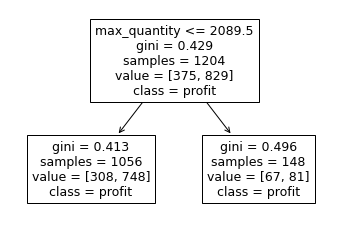

In [ ]:
# Еще раз бахнем решающее дерево, мб есть какая-то еще фича хорошая
train, test = train_test_split(df_total, test_size=0.3)
X_train = train.loc[:, "average_quantity" : "const"]
X_test = test.loc[:, "average_quantity" : "const"]
Y_train_profit_threshold = train.loc[:, "profit_threshold" : "profit_threshold"]
Y_train_loss_threshold = train.loc[:, "loss_threshold" : "loss_threshold"]
Y_train_has_profit = train.loc[:, "has_profit" : "has_profit"]
Y_test_profit_threshold = test.loc[:, "profit_threshold" : "profit_threshold"]
Y_test_loss_threshold = test.loc[:, "loss_threshold" : "loss_threshold"]
Y_test_has_profit = test.loc[:, "has_profit" : "has_profit"]
model.fit(X_train, Y_train_has_profit)
model.score(X_test, Y_test_has_profit)
from sklearn import tree
tree.plot_tree(
    model,
    feature_names=list(X_train.columns),
    class_names=["no profit", "profit"]
    )

In [ ]:
# Удалим все прыжки, длина которых меньше 100мс и посмотрим на прирост
print(f"Было: {df_total[df_total.has_profit == 1].shape[0] / df_total.shape[0]}")
df_total = df_total[df_total.max_quantity <= 2100]
print(f"Стало: {df_total[df_total.has_profit == 1].shape[0] / df_total.shape[0]}")

Было: 0.6815804764671702
Стало: 0.6950732356857523


Короче, ничего хорошего, всего 3 процента выигрываем, а терям кучу трейдов. Фигня какая-то

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs',random_state=0)
model.fit(X_train, Y_train_has_profit)
model.score(X_test, Y_test_has_profit)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6853396901072706